# 2D Structure Extraction (Hough Transform)
In this exercise, we will implement a Hough transform in order to detect parametric curves, such as lines or circles.
In the following, we shortly review the motivation for this technique.

Consider the point $p=(\mathtt{x},\mathtt{y})$ and the equation for a line $y = mx+c$. What are the lines that could pass through $p$?
The answer is simple: all the lines for which $m$ and $c$ satisfy $\mathtt{y} = m\mathtt{x}+c$.
Regarding $(\mathtt{x},\mathtt{y})$ as fixed, the last equation is that of a line in $(m,c)$-space.
Repeating this reasoning, a second point $p'=(\mathtt{x}',\mathtt{y}')$ will also have an associated line in parameter space, and the two lines will intersect at the point $(\tilde{m},\tilde{c})$, which corresponds to the line connecting $p$ and $p'$.

In order to find lines in the input image, we can thus pursue the following approach.
We start with an empty accumulator array quantizing the parameter space for $m$ and $c$.
For each edge pixel in the input image, we then draw a line in the accumulator array and increment the corresponding cells.
Edge pixels on the same line in the input image will produce intersecting lines in $(m,c)$-space and will thus reinforce the intersection point.
Maxima in this array thus correspond to lines in the input image that many edge pixels agree on.

In practice, the parametrization in terms of $m$ and $c$ is problematic, since the slope $m$ may become infinite.
Instead, we use the following parametrization in polar coordinates:
\begin{equation}
	\mathtt{x}\cos\theta + \mathtt{y}\sin\theta = \rho \label{eq:hough_line}
\end{equation}
This produces a sinusoidal curve in $(\rho,\theta)$-space, but otherwise the procedure is unchanged.

The following sub-questions will guide you through the steps of building a Hough transform.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from scipy import ndimage


Bad key "text.kerning_factor" on line 4 in
/home/pk/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Some convenience functions

In [2]:
def imread_gray(filename):
    """Read grayscale image from our data directory."""
    return cv2.imread(f'../data/{filename}', cv2.IMREAD_GRAYSCALE)

def imread_rgb(filename):
    """Read a color image from our data directory."""
    im = cv2.imread(f'../data/{filename}', cv2.IMREAD_COLOR)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def plot_hough(image, edges, hough_space):
    fig, axes = plt.subplots(1, 3, figsize=(3 * 4, 4))
    axes = axes.flat

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Image')
    
    axes[1].imshow(edges, cmap='gray')
    axes[1].set_title('Edges')
    
    axes[2].imshow(hough_space, cmap='hot')
    axes[2].set_title('Hough space')
    axes[2].set_xlabel('theta (index)')
    axes[2].set_ylabel('rho (index)')
    fig.tight_layout()
    
def plot_with_hough_lines(image_rgb, rhos, thetas):
    """Plot an image with lines drawn over it.
    The lines are specified as an array of rho values and
    and array of theta values.
    """
    
    rhos = np.asarray(rhos)
    thetas = np.asarray(thetas)

    # compute start and ending point of the line x*cos(theta)+y*sin(theta)=rho
    x0, x1 = 0, image.shape[1] - 1  # Draw line across image  
    y0 = rhos / np.sin(thetas)
    y1 = (rhos - x1 * np.cos(thetas)) / np.sin(thetas)

    # Check out this page for more drawing function in OpenCV:
    # https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
    for yy0, yy1 in zip(y0, y1):
        cv2.line(image_rgb, (x0, int(yy0)), (x1, int(yy1)), color=(255, 0, 0))

    return image_rgb

## Part a
Build up an accumulator array ``votes_acc`` for votes in the parameter space $(\rho, \theta)$. $\theta$ ranges from $-\pi/2$ to $\pi/2$, and $\rho$ ranges from $-D$ to $D$, where $D$ denotes the length of the image diagonal.
Use ``n_bins_rho`` and ``n_bins_theta`` as the number of bins in each direction.
Initially, the array should be filled with zeros.

For each edge pixel in the input image, create the corresponding curve in $(\rho, \theta)$ space by evaluating above line equation for all values of $\theta$ and increment the corresponding cells of the accumulator array.

In [3]:
def hough_transform(edge_image, n_bins_rho, n_bins_theta):
    # Vote accumulator
    votes = np.zeros((n_bins_rho, n_bins_theta), dtype=np.int)  
    
    # Create bins
    diag = np.linalg.norm(edge_image.shape)  # Length of image diagonal
    theta_bins = np.linspace(-np.pi / 2, np.pi / 2, n_bins_theta)
    rho_bins = np.linspace(-diag, diag, n_bins_rho)
    
    ### BEGIN SOLUTION
    # Precompute sine and cosine
    cos_thetas = np.cos(theta_bins)
    sin_thetas = np.sin(theta_bins)
    
    # Hough transform
    for x in range(edge_image.shape[1]):
        for y in range(edge_image.shape[0]):
            # If not an edge pixel, continue.
            if not edge_image[y, x]: #if edge_image==0: #not to count the points which are not edge
                continue
            
            # Cast votes
            for theta_idx, (cos_theta, sin_theta) in enumerate(zip(cos_thetas, sin_thetas)):
                # Compute rho given sine and cosine of theta
                rho = x * cos_theta + y * sin_theta  
                # Find bin index of rho
                rho_idx = int((rho+diag)/(2*diag)*n_bins_rho)  
                # Accumulate vote
                votes[rho_idx, theta_idx] += 1              
                
    ### END SOLUTION
    return votes, rho_bins, theta_bins

Test the implementation on an example image. Visualize the resulting Hough space by displaying it as a 2D image.

<IPython.core.display.Javascript object>


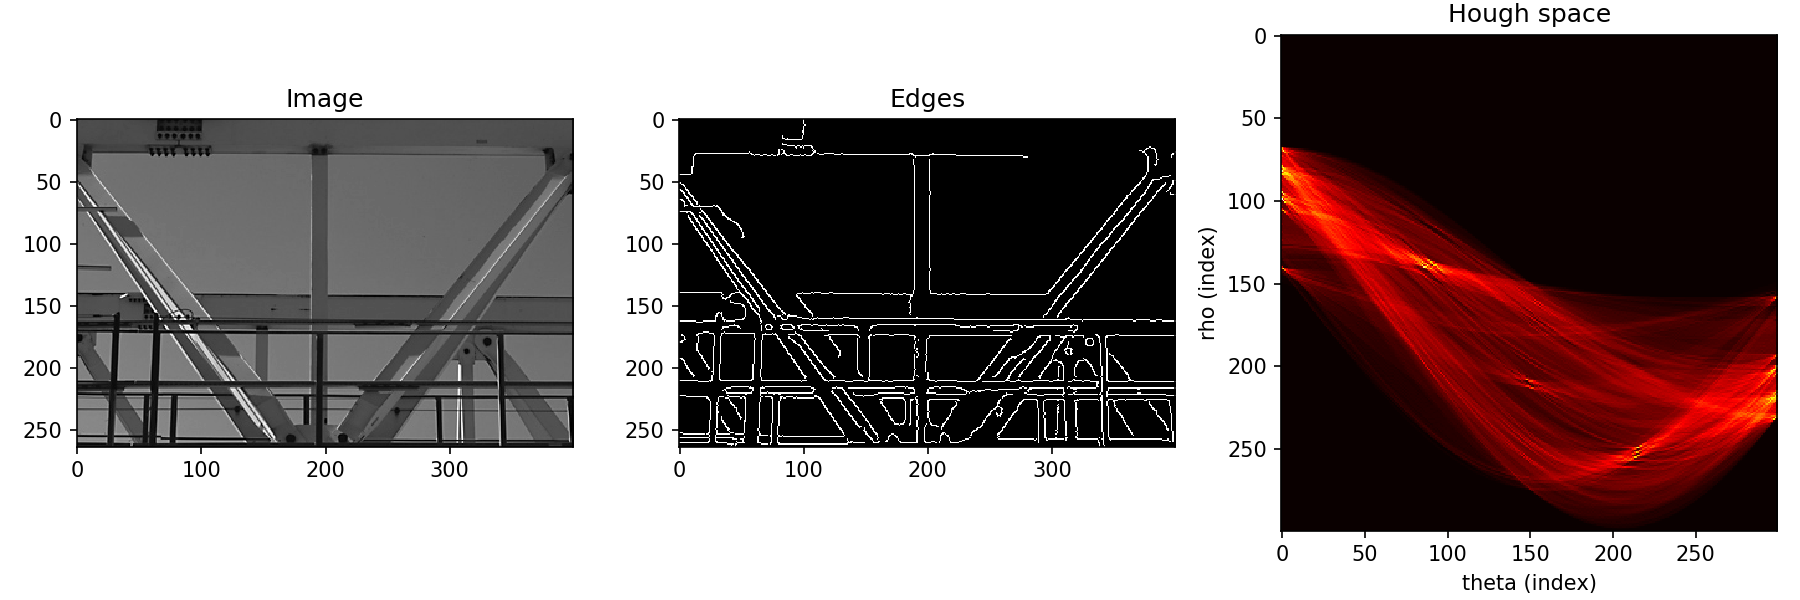

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [4]:
image = imread_gray('gantrycrane.png')

# Get edges using Canny
sigma = 2
kernel_size = 2 * int(3 * sigma) + 1
blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
edges = cv2.Canny(blurred, threshold1=30, threshold2=90)  # 30, 90 are manually tuned

n_bins_rho, n_bins_theta = 300, 300
hough_space, rho_bins, theta_bins = hough_transform(edges, n_bins_rho, n_bins_theta)
plot_hough(image, edges, hough_space)
edges

In [5]:
#data = np.asarray([ [10,20,30], [40,50,60], [70,80,90] ])
data =edges
np.savetxt("test.csv", data, delimiter=",")

In [6]:
edges[0,0]
sets = set(edges.flatten())
np.count_nonzero(edges)

7311

In [7]:
if not np.array([0]):
    print('run')

run


In [8]:
data = np.asarray([ [10,20,30], [40,50,60], [70,80,90] ])
result = np.where(data ==80)
data[result[0],result[1]]

array([80])

In [9]:
int(1.9)

1

## Part b
Write a function ``nms2d`` which suppresses all points in the Hough space that are not local maxima.
This can be achieved by looking at the 8 direct neighbors of each pixel and keeping only pixels whose value is greater than all its neighbors.
This function is simpler than the non-maximum suppression from the Canny Edge Detector since it does not take into account local gradients.

In [10]:
def nms2d(image):
    image_out = np.zeros_like(image)
    # Your code here
    
    
    
    for x in range(1,image_out.shape[1]-1):
        for y in range(1,image_out.shape[0]-1):
            val = image[y,x]
            
            x_neighbor = x + np.array([0,0,1,1,1,-1,-1,-1])
            y_neighbor = y + np.array([-1,1,-1,0,1,-1,0,1])
            val_neighbor = image[y_neighbor,x_neighbor]
            
            if np.all(val_neighbor<=val):
                image_out[y,x] = val
    
    return image_out

In [11]:
set(nms2d(hough_space).flatten())

{0,
 3,
 4,
 5,
 6,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189

Write a function ``find_hough_peaks`` that takes the result of ``hough_transform`` as an argument, finds the extrema in Hough space using ``nms2d`` and returns the index of all points $(\rho_i, \theta_i)$ for which the corresponding Hough value is greater than ``threshold``.

In [12]:
def find_hough_peaks(hough_space, threshold):
    hough_space_out = nms2d(hough_space)
    hough_space_out[hough_space_out<threshold] = 0
    
    return hough_space_out.nonzero()

In [13]:
hough_space_out2 = np.array(find_hough_peaks(hough_space, 250)).shape

In [14]:
hough_space_out2 #2 says there are two list : one for rho , one for theta

(2, 18)

In [15]:
 #this function is another version of above function with the same functionality
def find_hough_peaks(hough_space, threshold):
    hough_space_out = nms2d(hough_space)
    
    return np.where(hough_space_out>=threshold)

In [16]:
hough_space_out3 = np.array(find_hough_peaks(hough_space, 250))

In [17]:
hough_space_out3

array([[ 70,  80,  83,  96, 106, 137, 138, 139, 139, 140, 141, 141, 202,
        219, 221, 231, 249, 252],
       [  1,   1,   2,   1,   1,  85,  91,  88,  93,  86,   1,  90, 297,
        297, 295, 298, 215, 214]])

Try your implementation on the images ``gantrycrane.png`` and ``circuit.png``.
Do you find all the lines?

gantrycrane.png: found 18 lines in the image.


<IPython.core.display.Javascript object>


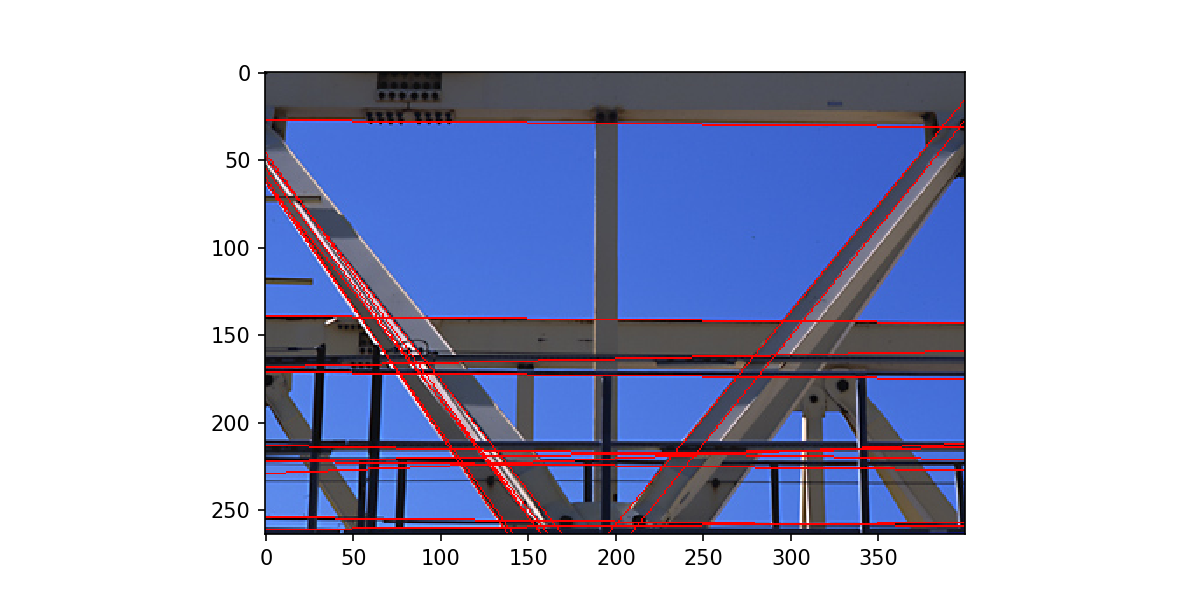

In [18]:
# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 250)
print(f'gantrycrane.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]

color_image = imread_rgb('gantrycrane.png')
image_with_lines = plot_with_hough_lines(color_image, rho_max, theta_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)

circuit.png: found 14 lines in the image.


<IPython.core.display.Javascript object>


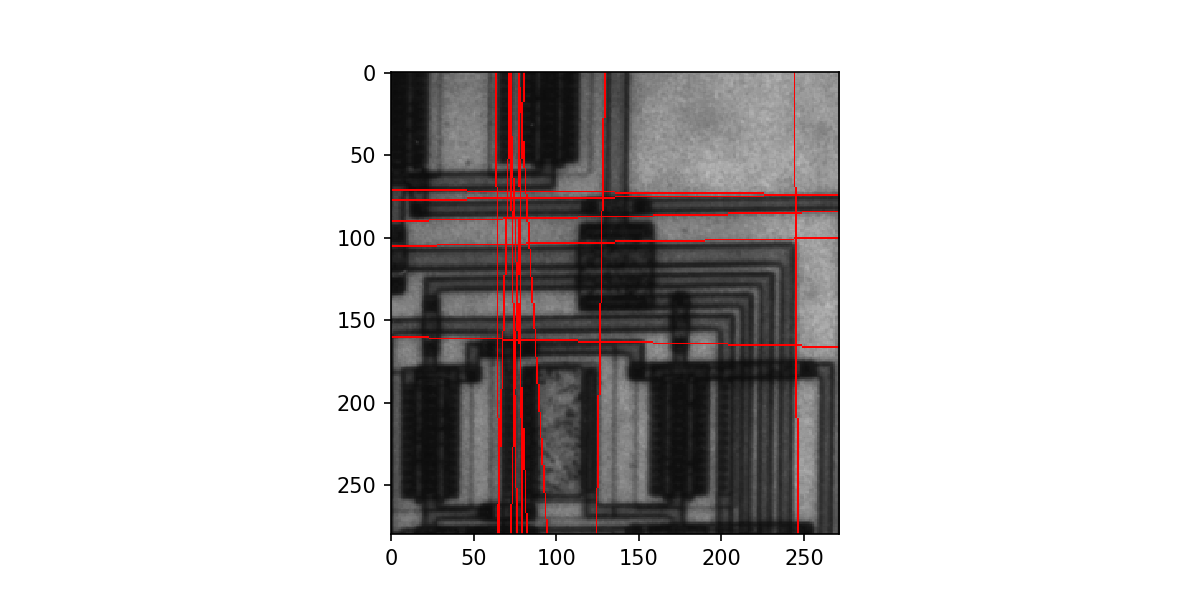

In [19]:
# Try another image
image = imread_gray('circuit.png')

sigma = 2
kernel_size = 2 * int(3 * sigma) + 1
blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
edge = cv2.Canny(blurred, threshold1=30, threshold2=90)
hough_space, rho_bins, theta_bins = hough_transform(edge, n_bins_rho, n_bins_theta)

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 130)
print('circuit.png: found {} lines in the image.'.format(len(rho_max_idx)))
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]
color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image_with_lines = plot_with_hough_lines(color_image, rho_max, theta_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)

In [20]:
rh, th = np.array(find_hough_peaks(hough_space, 130))
rh, th

(array([ 88, 122, 174, 177, 177, 177, 179, 179, 179, 180, 184, 190, 199,
        243]),
 array([  2,   1, 149, 146, 148, 152, 144, 149, 298, 152, 297, 297, 151,
        149]))

**Do you find all the lines? Type your answer here:**
    
----

## Part c (bonus)

The Hough transform is a general technique that can not only be applied to lines, but also to other parametric curves, such as circles.
In the following, we will show how the implementation can be extended to finding circles.

A circle can be parameterized by the following equation:
$$	
    (\mathtt{x}-a)^2 + (\mathtt{y}-b)^2 = r^2. \label{eq:hough_circle}
$$

Unfortunately, the computation and memory requirements for the Hough transform increase exponentially with the number of parameters.
While a 3D search space is still just feasible, we can dramatically reduce the amount of computation by integrating the gradient direction in the algorithm.

Without gradient information, all values $a, b$ lying on the cone given by above equation are incremented.
With the gradient information, we only need to increment points on an arc centered at $(a, b)$:
$$
\begin{eqnarray}
	a &=& x + r\cos\phi\\
	b &=& y + r\sin\phi,
\end{eqnarray}
$$
where $\phi$ is the gradient angle returned by the edge operator.

Create a function ``hough_circle`` which implements the Hough transform for circles.
Try your implementation for a practical application of counting coins in an image.
    def image_gradients_polar(image, sigma):
    dx, dy = gauss_derivs(image, sigma)
    magnitude = np.sqrt(dx**2 + dy**2)
    direction = np.arctan2(dy, dx)  # between -pi and +pi
    return magnitude, directionYou can use the images ``coins1.png`` and ``coins2.png`` for testing.

In [23]:
def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1)
    image = ndimage.convolve(image, kernel2)   
    return image

# From Question 2: Image Derivatives
def gauss_derivs(image, sigma):
    kernel_radius = int(3.0 * sigma)
    x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
    
    # Compute 1D Gaussian kernel 
    gaussderiv_kernel1d = -1 / np.sqrt(2 * np.pi) / sigma**3 * x * np.exp(-x**2.0 / 2 / sigma**2)
    # Compute 1D Derivative-of-Gaussian kernel
    gauss_kernel1d = 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-x**2 / 2 / sigma**2)
    
    image_dx = convolve_with_two(image, gaussderiv_kernel1d, gauss_kernel1d.T)
    image_dy = convolve_with_two(image, gauss_kernel1d, gaussderiv_kernel1d.T)
    return image_dx, image_dy

def image_gradients_polar(image, sigma):
    dx, dy = gauss_derivs(image, sigma)
    magnitude = np.sqrt(dx**2 + dy**2)
    direction = np.arctan2(dy, dx)  # between -pi and +pi
    return magnitude, direction

###############################################################

def hough_transform(edge_image, n_bins_rho):
    # Vote accumulator
    votes = np.zeros((n_bins_rho, edge.shape[1],edge.shape[0]), dtype=np.int)  
    
    # Create bins
    
    a_bins = np.linspace(0,edge.shape[1]-1,edge.shape[1])
    b_bins = np.linspace(0,edge.shape[0]-1,edge.shape[0])
    
    diag = max(edge.shape)  # maximum length of radius
    rho_bins = np.linspace(0, diag, n_bins_rho)
    
    ### BEGIN SOLUTION
    # Precompute sine and cosine
    magnitude, direction = image_gradients_polar(edge_image, sigma=2)
    
    theta = direction
    
    # Hough transform
    for x in range(edge_image.shape[1]):
        for y in range(edge_image.shape[0]):
            # If not an edge pixel, continue.
            if not edge_image[y, x]: #if edge_image==0: #not to count the points which are not edge
                continue
            
            # Cast votes
            for theta_idx, (cos_theta, sin_theta) in enumerate(zip(cos_thetas, sin_thetas)):
                # Compute rho given sine and cosine of theta
                rho = x * cos_theta + y * sin_theta  
                # Find bin index of rho
                rho_idx = int((rho+diag)/(2*diag)*n_bins_rho)  
                # Accumulate vote
                votes[rho_idx, a_idx,b_idx] += 1              
                
    ### END SOLUTION
    return votes, rho_bins, theta_bins

In [24]:
image = imread_gray('coins1.jpg')

# Get edges using Canny
sigma = 2
kernel_size = 2 * int(3 * sigma) + 1
blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
edges = cv2.Canny(blurred, threshold1=30, threshold2=90)  # 30, 90 are manually tuned

n_bins_rho, n_bins_theta = 300, 300
hough_space, rho_bins, theta_bins = hough_transform(edges, n_bins_rho, n_bins_theta)


NameError: name 'cos_thetas' is not defined

In [30]:
(edge.shape)

(280, 272)

In [31]:
max(edge.shape)

280

In [35]:
a_bins = np.linspace(0,edge.shape[1]-1,edge.shape[1])
b_bins = np.linspace(0,edge.shape[0]-1,edge.shape[0])
b_bins

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

## Pard d (bonus)
The same trick (as in **Part c**) of using the image gradient can be used for lines.
Modify the code from **Part a** to only vote for one line per edge pixel, instead of all the lines running through this pixel.

## Part e (bonus)
Can you build an online coin classification and counting system?

You can take a look at the ``Haribo classification`` demo (MATLAB) in the Moodle for some ideas. Use the functions you wrote in the previous questions.
(Hint: you may need to include a reference shape in the picture in order to obtain the absolute scale).